# MPS simulation of a continuos variable

> **Note** This notebook is inspired by the notebook [ex_deesse_04_continuous_sim.ipynb](https://github.com/randlab/geone/blob/master/examples/ex_deesse_04_continuous_sim.ipynb), by Julien Straubhaar.  
> Please refer to that notebook for more details and to explore all the available options.

In this notebook, we will explore how do deal with the simulation of continuos variables with the DS. Note that the simulation of continuous variables can be tackled from different perspectives. For example, by default the range of variability of the variable to be simulated should be in agreement with the range of variability observed in the training image (TI) and in the conditioning hard data. Some simulation modes (see for more details [ex_deesse_04_continuous_sim.ipynb](https://github.com/randlab/geone/blob/master/examples/ex_deesse_04_continuous_sim.ipynb)) allow to simulate over a different range of variability. Another possibily is to use the so said "relative distance", when the distance from data events is computed taking in consideration the overall trend of the data, providing an additional way to take into account some spatial trend in the hard data (see for more details [ex_deesse_04_continuous_sim.ipynb](https://github.com/randlab/geone/blob/master/examples/ex_deesse_04_continuous_sim.ipynb)).

As many steps are quite similar to the notebook where we illustrate the simulation of categorical variables (`mps01_basic.ipynb`), here we will focus only on the different steps.

First of all, import the required modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os

# import from 'geone'
import geone as gn

## Import the training image

A training image (TI) is required to apply MPS. In this case we will use a continuous training image form the study of Zhang et al (see the section **References** for more details).

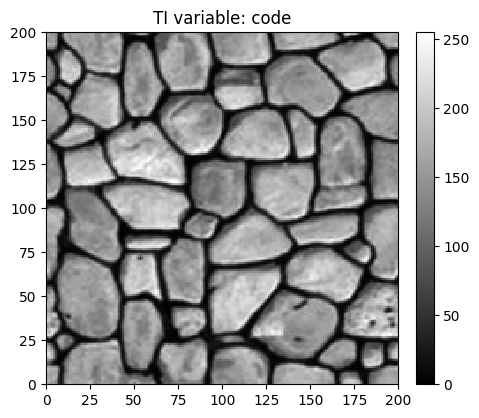

In [2]:
# Read file 
ti = gn.img.readImageTxt('tiContinuous.txt')

# Color settings
cmap='grey'
vmin, vmax = ti.vmin(), ti.vmax()

# Plot
plt.figure(figsize=(5,5))
gn.imgplot.drawImage2D(ti, cmap=cmap, vmin=vmin, vmax=vmax)
plt.title(f'TI variable: {ti.varname[0]}')
plt.show()

## Define the simulation grid
Define the simulation grid (number of cells in each direction, cell unit, origin).

In [3]:
nx, ny, nz = 300, 120, 1         # number of cells
sx, sy, sz = ti.sx, ti.sy, ti.sz # cell unit, same as TI
ox, oy, oz = 0.0, 0.0, 0.0       # origin (corner of the "first" grid cell)

## Define and plot hard data
Define some hard data (point set).

In [4]:
npt = 5 # number of points
nv = 4   # number of variables including x, y, z coordinates
varname = ['x', 'y', 'z', 'code'] # list of variable names
v = np.array([
    [ 10.5,  20.5, 0.5,  30], # x, y, z, code: 1st point
    [229.5,  21.5, 0.5, 132], # ...
    [ 98.5,  27.5, 0.5,  10],
    [245.5,  94.5, 0.5, 189],
    [ 87.5, 110.5, 0.5,   2]
    ]).T # variable values: (nv, npt)-array
hd = gn.img.PointSet(npt=npt, nv=nv, varname=varname, val=v)

Plot the hard data points in the simulation grid.

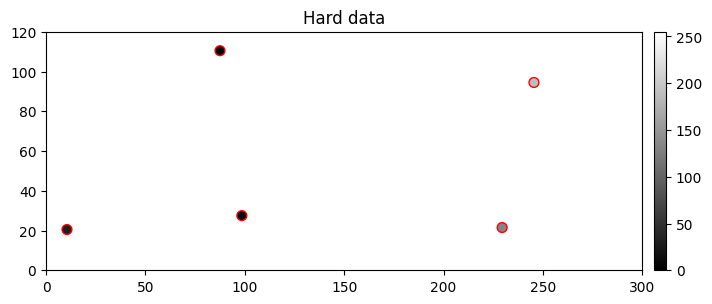

In [5]:
# Get the colors for values of the variable of index 3 in the point set, 
# according to the color settings used for the TI
hd_col = gn.imgplot.get_colors_from_values(hd.val[3], cmap=cmap, vmin=vmin, vmax=vmax)

# Set an image with simulation grid geometry defined above, and no variable
im_empty = gn.img.Img(nx, ny, nz, sx, sy, sz, ox, oy, oz, nv=0)

# Plot
plt.figure(figsize=(8,5))

# Plot empty simulation grid and specify colors
gn.imgplot.drawImage2D(im_empty, cmap=cmap, vmin=vmin, vmax=vmax)

# Add hard data points
plt.scatter(hd.x(), hd.y(), marker='o', s=50, color=hd_col, edgecolors='red', linewidths=1)

plt.title('Hard data')
plt.show()

## Setting the input parameters

> **Reminder:** variable name for the hard data (in `hd.varname`) and for the simulated variable (`varname` below) should be the same, otherwise, the hard data will be ignored.

In [9]:
nreal = 20
deesse_input = gn.deesseinterface.DeesseInput(
    nx=nx, ny=ny, nz=nz,
    sx=sx, sy=sy, sz=sz,
    ox=ox, oy=oy, oz=oz,
    nv=1, varname='code',
    TI=ti,
    dataPointSet=hd,
    distanceType='continuous',           # distance type: L1 (continuous variable)
    nneighboringNode=24,
    distanceThreshold=0.02,
    maxScanFraction=0.25,
    npostProcessingPathMax=1,
    seed=444,
    nrealization=nreal)

## Run the DS simulation

In [11]:
deesse_output = gn.deesseinterface.deesseRun(deesse_input, nthreads=4)

DeeSse running... [VERSION 3.2 / BUILD NUMBER 20230914 / OpenMP 4 thread(s)]
DeeSse run complete


## Retrieve the results and display

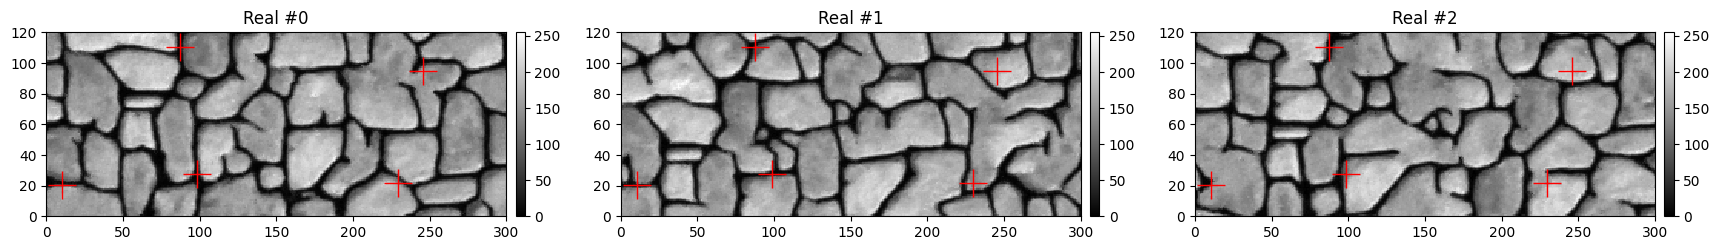

In [12]:
# Retrieve the realizations
sim = deesse_output['sim']

# Display
plt.subplots(1,3, figsize=(21,3)) # 1 x 3 sub-plots
for i in range(3):
    plt.subplot(1, 3, i+1) # select next sub-plot
    gn.imgplot.drawImage2D(sim[i], cmap=gn.customcolors.cmapB2W, vmin=ti.vmin(), vmax=ti.vmax(), 
                           title=f'Real #{i}') # plot real #i
    plt.plot(hd.x(), hd.y(), '+', markersize=20, c='red') # add hard data points
plt.show()

## Do some statistics on the realizations and display the results

The function `geone.img.imageContStat(im, op)` allows to compute some pixel-wise operation. The first input argument (`im`) is the *Image* object, while the second argument (`op`) allows to define the kind of pixel-wise operation to be performed. For example, one can select *mean* or the *standard deviation* (see the function documentation for the precise keywords and for more details). First, an image with `nreal` variables, each one corresponding to one realization, is defined (from the array of realizations) using the function `geone.img.gatherImages`.

Alternatively, the function `geone.img.imageListContStat(im_list, op, ind)` can be used directly to compute the pixel-wise statistics according to operation `op` over the variable of index `ind` of all the images in the list `im_list`.

In [13]:
# Gather the nreal realizations into one image
all_sim = gn.img.gatherImages(sim) # all_sim is one image with nreal variables

# Do statistics over all the realizations: compute the pixel-wise mean and standard deviation
all_sim_mean = gn.img.imageContStat(all_sim, 'mean') # do statistics (pixel-wise mean)
all_sim_std = gn.img.imageContStat(all_sim, 'std')   # do statistics (pixel-wise standard deviation)

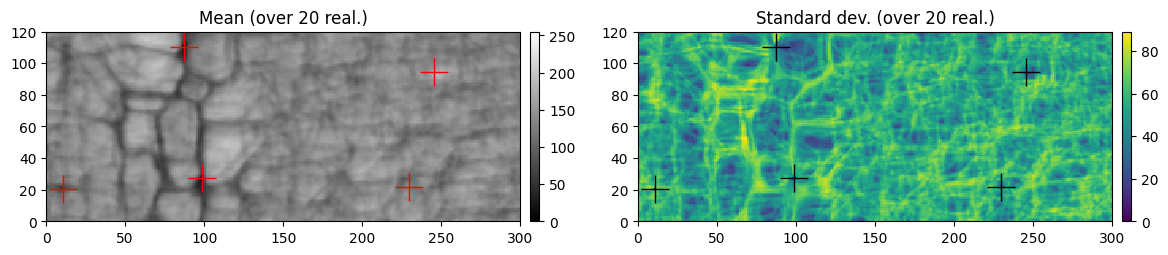

In [14]:
# Display
plt.subplots(1,2, figsize=(14,3)) # 1 x 2 plots

plt.subplot(1,2,1) # select 1st sub-plot
gn.imgplot.drawImage2D(all_sim_mean, cmap=gn.customcolors.cmapB2W, vmin=ti.vmin(), vmax=ti.vmax(), 
                       title=f'Mean (over {nreal} real.)')
plt.plot(hd.x(), hd.y(), '+', markersize=20, c='r') # add hard data points

plt.subplot(1,2,2) # select 2nd sub-plot
gn.imgplot.drawImage2D(all_sim_std, title=f'Standard dev. (over {nreal} real.)')
plt.plot(hd.x(), hd.y(), '+', markersize=20, c='k') # add hard data points

plt.show()